In [2]:
import numpy as np
from pathlib import Path
import pandas as pd
import holoviews as hv
import hvplot.pandas
import geoviews as gv
import geopandas as gpd

hv.extension('bokeh')

In [3]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/tiger1/pdas47/tmsosPP/src")

from tmsswot.tmsswot import calculate_storage

## Parameters

In [4]:
TIME_RANGE = (
    pd.to_datetime('2023-07-21'),
    pd.to_datetime('2024-10-30')
)

## Global map of reservoirs

In [5]:
val_pts = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/100-validation-reservoirs-grand-pts.geojson'))
val_polys = gpd.read_file(Path('/tiger1/pdas47/tmsosPP/data/validation-locations/100-validation-reservoirs-grand-polys.geojson'))

global_map = (
    val_pts.hvplot(
        geo=True, tiles='OSM'
    )
).opts(
    title=f"Locations of validation reservoirs"
)

global_map

:Overlay
   .WMTS.I   :WMTS   [Longitude,Latitude]
   .Points.I :Points   [Longitude,Latitude]

In [6]:
def calculate_perimeter(geometry, crs="EPSG:4326"):
    """
    Calculates the perimeter of a given geometry in its estimated UTM projection.

    Parameters:
        geometry (shapely.geometry.base.BaseGeometry): The geometry object for which to calculate the perimeter.
        crs (str, optional): The coordinate reference system of the input geometry. Default is "EPSG:4326".

    Returns:
        float: The perimeter of the geometry in meters.
    """
    # Coerce to GeoDataFrame
    gdf = gpd.GeoDataFrame(geometry=[geometry], crs=crs)
    
    # Estimate UTM CRS
    utm_crs = gdf.estimate_utm_crs()
    
    # Convert to UTM CRS
    gdf = gdf.to_crs(utm_crs)
    
    # Calculate perimeter in meters
    perimeter = gdf.geometry.length.iloc[0]
    
    return perimeter

## Read AECS

In [7]:
# Get unique tmsos_ids from combined_df
unique_tmsos_ids = val_pts['tmsos_id'].unique()

# Directory containing AEC files
aec_dir = Path('/tiger1/pdas47/tmsosPP/data/aec/aev')

# Initialize an empty dictionary to store the AEC dataframes
aec_dict = {}

# Iterate over each unique tmsos_id and read the corresponding AEC file
for tmsos_id in unique_tmsos_ids:
    aec_fp = aec_dir / f'{tmsos_id}.csv'
    if aec_fp.exists():
        aec_df = pd.read_csv(aec_fp, comment='#')
        aec_dict[tmsos_id] = aec_df

# Display the keys of the dictionary to verify
print(aec_dict.keys())

dict_keys(['0214', '0569', '0488', '0516', '0502', '0532', '0518', '0552', '0837', '0839', '0930', '0931', '0933', '0934', '0935', '0936', '1078', '1088', '1097', '1128', '1134', '1135', '1162', '1164', '1177', '1190', '1441', '1213', '1444', '1447', '1239', '1487', '1498', '1284', '1298', '0787', '0676', '0725', '1320', '1383', '1385', '1388', '1392', '1393', '1398', '1400', '1407', '0079', '0078', '0217', '0197', '0193', '0340', '0335', '0349', '0364', '0365', '0445', '0375', '0464', '0440', '0484', '0512', '0503', '0535', '0538', '0530', '0529', '0492', '0487', '0493', '0498', '0486', '0508', '0507', '0523', '0524', '0553', '0551', '0549', '0574', '0576', '0827', '0806', '0824', '0833', '0807', '0819', '0828', '0812', '0803', '0830', '0816', '0821', '0820', '0817', '0810', '1425', '1426', '0505'])


# Data prep

## Read non-swot satellite data

In [8]:
tmsos_dir = Path("/tiger1/pdas47/tmsosPP/data/tmsos")

tmsos_dfs = []
for reservoir in val_polys['tmsos_id']:
    tmsos_fp = tmsos_dir / f'{reservoir}.csv'
    tmsos_df = pd.read_csv(tmsos_fp, parse_dates=['date'])
    tmsos_df['tmsos_id'] = reservoir
    tmsos_dfs.append(tmsos_df)

tmsos_df = pd.concat(tmsos_dfs)
tmsos_df.head()

date  water_area_uncorrected  non_water_area  cloud_area  \
0 2019-02-01                3.909687        5.307815   10.767227   
1 2019-02-02                4.774675       13.761307    1.839912   
2 2019-02-07                1.100860        3.372829   15.902206   
3 2019-02-12                0.000000        0.000000         NaN   
4 2019-02-17                0.000000        0.000000         NaN   

   unfiltered_area  cloud_percent  QUALITY_DESCRIPTION sat  filtered_area  \
0         9.435533      53.877272                  0.0  l8       9.435533   
1              NaN       9.029849                  0.0  s2            NaN   
2         8.221767      78.044210                  0.0  s2       8.221767   
3         8.592664     100.000000                  0.0  s2       8.592664   
4              NaN     100.000000                  0.0  s2            NaN   

   corrected_areas_1  corrected_trend_1  sar_trend  days_passed      area  \
0           9.435533           0.062695  -0.078867          4.0  9.435533   
1                NaN                NaN  -0.078867          1.0  9.356666   
2           8.221767          -0.202294  -0.078867          5.0  8.221767   
3           8.592664           0.074179  -0.078867          5.0  8.592664   
4                NaN                NaN  -0.078867          5.0  8.198330   

  tmsos_id  
0     0837  
1     0837  
2     0837  
3     0837  
4     0837

In [9]:
tmsos_df.columns

Index(['date', 'water_area_uncorrected', 'non_water_area', 'cloud_area',
       'unfiltered_area', 'cloud_percent', 'QUALITY_DESCRIPTION', 'sat',
       'filtered_area', 'corrected_areas_1', 'corrected_trend_1', 'sar_trend',
       'days_passed', 'area', 'tmsos_id'],
      dtype='object')

In [10]:
df = tmsos_df[[
    'date', 'tmsos_id', 'cloud_percent', 'area', 'corrected_areas_1', 'filtered_area', 'unfiltered_area',
    'sat'
]]

In [11]:
import hvplot.pandas

# Filter the dataframe for the specified reservoir
reservoir_df = df[df['tmsos_id'] == '0810']

# Plot the time series
# cloud_percent_plot = reservoir_df.hvplot.line(x='date', y='cloud_percent', label='Cloud Percent')
area_plot = reservoir_df.hvplot.scatter(x='date', y='area', label='Area', color='sat')
corrected_areas_1_plot = reservoir_df.hvplot.scatter(x='date', y='corrected_areas_1', label='Corrected Areas 1', color='sat')
filtered_area_plot = reservoir_df.hvplot.scatter(x='date', y='filtered_area', label='Filtered Area', color='sat')
unfiltered_area_plot = reservoir_df.hvplot.scatter(x='date', y='unfiltered_area', label='Unfiltered Area', color='sat')

# Overlay the plots
overlay = (area_plot * corrected_areas_1_plot * filtered_area_plot * unfiltered_area_plot).opts(
    title='Time Series for Reservoir 0505',
    xlabel='Date',
    ylabel='Values',
    legend_position='top_left',
    height=400,
    width=800
)

overlay

:Overlay
   .Scatter.Area              :Scatter   [date]   (area,sat)
   .Scatter.Corrected_Areas_1 :Scatter   [date]   (corrected_areas_1,sat)
   .Scatter.Filtered_Area     :Scatter   [date]   (filtered_area,sat)
   .Scatter.Unfiltered_Area   :Scatter   [date]   (unfiltered_area,sat)

### Combine data

In [12]:
# # Combine areas from all dataframes
# combined_df = pd.concat([
#     # l8_df[['date_dmy', 'uncorrected_area', 'tmsos_id', 'cloud_pct']].assign(sensor='Landsat 8'),
#     # l9_df[['date_dmy', 'uncorrected_area', 'tmsos_id', 'cloud_pct']].assign(sensor='Landsat 9'),
#     # s2_df[['date_dmy', 'uncorrected_area', 'tmsos_id', 'cloud_pct']].assign(sensor='Sentinel 2'),
#     # s1_df[['date_dmy', 'uncorrected_area', 'tmsos_id']].assign(sensor='Sentinel 1')
# ])

combined_df = tmsos_df[[
    'date', 'water_area_uncorrected', 'tmsos_id', 'unfiltered_area', 'cloud_percent', 'sat'
]].rename({'water_area_uncorrected': 'uncorrected_area', 'sat': 'sensor'}, axis=1)

# Convert date_dmy to YYYYMMDD format
combined_df['date_dmy'] = pd.to_datetime(combined_df['date']).dt.strftime('%Y%m%d')

# # Save date as a separate column in datetime format
# combined_df['date'] = pd.to_datetime(combined_df['date_dmy'], format='%Y%m%d')

# Sort by the new date column
combined_df = combined_df.sort_values(by='date')

combined_df = combined_df.dropna(subset='uncorrected_area')

combined_df.head()

date  uncorrected_area tmsos_id  unfiltered_area  cloud_percent  \
0 2019-01-03         79.098898     0569        79.098898       0.235375   
0 2019-01-03        244.827040     0484       244.841131       0.276415   
0 2019-01-07         61.281229     0487        61.281978       0.306453   
0 2019-01-07         37.136488     0820        46.655046      20.136252   
0 2019-01-07         29.800918     0530        34.196894      13.770361   

  sensor  date_dmy  
0     s2  20190103  
0     s2  20190103  
0     s2  20190107  
0     s2  20190107  
0     s2  20190107

In [13]:
# bad_reservoirs = ['0817']

# combined_df = combined_df[~combined_df['tmsos_id'].isin(bad_reservoirs)]

In [14]:
RESERVOIR = '1383'

combined_df[combined_df['tmsos_id'] == RESERVOIR].hvplot(
    x='date', y='unfiltered_area', kind='scatter', c='cloud_percent'
).opts(
    cmap='RdYlGn_r', clabel='Cloud percent',
    title=f'Uncorrected Area over Time for Reservoir {RESERVOIR}'
)

:Scatter   [date]   (unfiltered_area,cloud_percent)

### Add climate data

In [15]:
import rioxarray as rio
import xarray as xr
import hvplot.xarray

In [16]:
koppen_geiger_climate = rio.open_rasterio(
    Path("/tiger1/pdas47/tmsosPP/data/climate/koppen_geiger_0p1.tif"), band_as_variable=True
).rename({'band_1': 'climate'})
koppen_geiger_climate['climate'].hvplot(x='x', y='y', geo=True, cmap='Category20')

:Image   [x,y]   (climate)

In [17]:
# Extract coordinates from val_pts
coords = val_pts.geometry.apply(lambda geom: (geom.x, geom.y))

# Sample climate values from koppen_geiger_climate
climate_values = koppen_geiger_climate.sel(
    x=xr.DataArray(coords.apply(lambda c: c[0]), dims="points"),
    y=xr.DataArray(coords.apply(lambda c: c[1]), dims="points"),
    method="nearest"
).climate.values

# Add the sampled climate values to val_pts
val_pts['sampled_climate'] = climate_values

val_pts.hvplot(
    geo=True, x='sampled_climate', cmap='Set1'
)

:Points   [Longitude,Latitude]   (sampled_climate)

In [18]:
# Define the mapping function
def transform_climate(value):
    if 1 <= value <= 3:
        return 'A'
    elif 4 <= value <= 7:
        return 'B'
    elif 8 <= value <= 16:
        return 'C'
    elif 17 <= value <= 28:
        return 'D'
    elif 29 <= value <= 30:
        return 'E'
    else:
        return value

# # Apply the transformation
# val_pts['climate'] = val_pts['sampled_climate'].map(transform_climate)  # reduce the amount of information is stored

# Apply the transformation
val_pts['climate'] = val_pts['sampled_climate']
# calculate perimeter from geometry
val_polys['perimeter'] = val_polys['geometry'].apply(calculate_perimeter)
# calculate regularity index as the ratio of Area over the Perimeter (A/P)
val_polys['regularity'] = val_polys['AREA_POLY'] * 1e6 / val_polys['perimeter']

# Join val_pts with combined_df on 'tmsos_id'
combined_df = combined_df.merge(val_pts[['tmsos_id', 'climate', 'CAP_MCM']], on='tmsos_id', how='left')
combined_df = combined_df.merge(val_polys[['tmsos_id', 'regularity']], on='tmsos_id', how='left')
combined_df['month'] = combined_df['date'].dt.month
combined_df['year'] = combined_df['date'].dt.year
combined_df['season'] = combined_df['month'].map(lambda m: 'Winter' if m in [12, 1, 2] else 'Spring' if m in [3, 4, 5] else 'Summer' if m in [6, 7, 8] else 'Autumn')

In [19]:
combined_df

date  uncorrected_area tmsos_id  unfiltered_area  cloud_percent  \
0     2019-01-03         79.098898     0569        79.098898       0.235375   
1     2019-01-03        244.827040     0484       244.841131       0.276415   
2     2019-01-07         61.281229     0487        61.281978       0.306453   
3     2019-01-07         37.136488     0820        46.655046      20.136252   
4     2019-01-07         29.800918     0530        34.196894      13.770361   
...          ...               ...      ...              ...            ...   
55646 2024-09-07         59.219414     1425              NaN       0.034213   
55647 2024-09-07          6.162017     1164              NaN      -0.088192   
55648 2024-09-07         13.388716     0445              NaN       0.142894   
55649 2024-09-07          0.000000     0817       157.853726     100.620843   
55650 2024-09-08          0.000000     0553              NaN     101.219058   

      sensor  date_dmy  climate  CAP_MCM  regularity  month  year  season  
0         s2  20190103        3    419.1  288.746778      1  2019  Winter  
1         s2  20190103        3   8510.0  705.030284      1  2019  Winter  
2         s2  20190107        3   1254.0  455.305982      1  2019  Winter  
3         s2  20190107        3    710.0  478.337976      1  2019  Winter  
4         s2  20190107        3    539.0  368.580245      1  2019  Winter  
...      ...       ...      ...      ...         ...    ...   ...     ...  
55646     l9  20240907       14    789.7  449.217993      9  2024  Autumn  
55647     l9  20240907       25    495.4  570.488595      9  2024  Autumn  
55648     l9  20240907       12    279.6  309.853247      9  2024  Autumn  
55649     l8  20240907        2   5640.0  217.643784      9  2024  Autumn  
55650     l9  20240908        6   1369.0  361.229279      9  2024  Autumn  

[55651 rows x 13 columns]

### Add elevation and slope

In [20]:
import ee

ee.Initialize()

def get_average_elevation_and_slope(polygon, buffer_distance, ee_dem_name='MERIT/DEM/v1_0_3'):
    """
    Gets the average elevation and slope within a buffer distance around a specific polygon.

    Parameters:
        polygon (shapely.geometry.Polygon): The polygon object of interest.
        buffer_distance (float): Buffer distance in meters.
        ee_dem_name (str, optional): Name of the Earth Engine DEM dataset. Default is 'MERIT/DEM/v1_0_3'.
    
    Returns:
        tuple: The average elevation and slope within the buffer distance.
    """
    # Convert the polygon to a GeoJSON-like dictionary
    polygon_geojson = ee.Geometry.Polygon(list(polygon.exterior.coords))
    
    # Create a buffer around the polygon
    buffer = polygon_geojson.buffer(buffer_distance)
    
    # Load the DEM dataset
    dem = ee.Image(ee_dem_name)
    
    # Calculate slope
    slope = ee.Terrain.slope(dem)
    
    # Get the mean elevation and slope within the buffer
    mean_elevation = dem.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=buffer,
        scale=30
    ).get('dem').getInfo()
    
    mean_slope = slope.reduceRegion(
        reducer=ee.Reducer.mean(),
        geometry=buffer,
        scale=30
    ).get('slope').getInfo()
    
    return mean_elevation, mean_slope

# Apply the function to the first element of val_polys
buffer_distance = 1000  # Example buffer distance in meters
val_res_poly = val_polys[val_polys['tmsos_id'] == '0505'].iloc[0]['geometry']
elevation, slope = get_average_elevation_and_slope(val_res_poly, 1000)
print(elevation, slope)

96.31324809747682 1.2342194217396565


In [21]:
slope_elev_fn = Path("/tiger1/pdas47/tmsosPP/data/elevation/slope-elevation.csv")

if slope_elev_fn.exists():
    slope_elev = pd.read_csv(slope_elev_fn, dtype={'tmsos_id': str}).drop('Unnamed: 0', axis=1)
else:
    from tqdm import tqdm

    # Initialize lists to store elevation and slope values
    elevations = []
    slopes = []

    # Iterate over each polygon in val_polys and calculate elevation and slope
    for idx, row in tqdm(val_polys.iterrows(), total=val_polys.shape[0], desc="Calculating elevation and slope"):
        elevation, slope = get_average_elevation_and_slope(row['geometry'], buffer_distance)
        elevations.append(elevation)
        slopes.append(slope)

    # Add the calculated elevation and slope to the val_polys dataframe
    slope_elev = pd.DataFrame({
        'tmsos_id': val_polys['tmsos_id'],
        'elevation': elevations,
        'slope': slopes
    })

slope_elev

tmsos_id   elevation      slope
0      0837  838.394880  10.904619
1      0839  802.423290  13.852112
2      0930  860.643259  13.464009
3      0931  700.646604  14.419128
4      0933  700.438985  11.735284
..      ...         ...        ...
95     0820  122.317869   6.304306
96     0817  153.685392  12.272303
97     0810  144.724128   0.917971
98     1425  171.180364   1.912986
99     1426  159.729158   2.277652

[100 rows x 3 columns]

In [22]:
combined_df

date  uncorrected_area tmsos_id  unfiltered_area  cloud_percent  \
0     2019-01-03         79.098898     0569        79.098898       0.235375   
1     2019-01-03        244.827040     0484       244.841131       0.276415   
2     2019-01-07         61.281229     0487        61.281978       0.306453   
3     2019-01-07         37.136488     0820        46.655046      20.136252   
4     2019-01-07         29.800918     0530        34.196894      13.770361   
...          ...               ...      ...              ...            ...   
55646 2024-09-07         59.219414     1425              NaN       0.034213   
55647 2024-09-07          6.162017     1164              NaN      -0.088192   
55648 2024-09-07         13.388716     0445              NaN       0.142894   
55649 2024-09-07          0.000000     0817       157.853726     100.620843   
55650 2024-09-08          0.000000     0553              NaN     101.219058   

      sensor  date_dmy  climate  CAP_MCM  regularity  month  year  season  
0         s2  20190103        3    419.1  288.746778      1  2019  Winter  
1         s2  20190103        3   8510.0  705.030284      1  2019  Winter  
2         s2  20190107        3   1254.0  455.305982      1  2019  Winter  
3         s2  20190107        3    710.0  478.337976      1  2019  Winter  
4         s2  20190107        3    539.0  368.580245      1  2019  Winter  
...      ...       ...      ...      ...         ...    ...   ...     ...  
55646     l9  20240907       14    789.7  449.217993      9  2024  Autumn  
55647     l9  20240907       25    495.4  570.488595      9  2024  Autumn  
55648     l9  20240907       12    279.6  309.853247      9  2024  Autumn  
55649     l8  20240907        2   5640.0  217.643784      9  2024  Autumn  
55650     l9  20240908        6   1369.0  361.229279      9  2024  Autumn  

[55651 rows x 13 columns]

In [23]:
combined_df = combined_df.merge(slope_elev[['tmsos_id', 'elevation', 'slope']], on='tmsos_id', how='left')

### Calculate storage from uncorrected areas

In [24]:
# Function to calculate storage for each tmsos_id group
def calculate_storage_for_group(group, aec_dict, area_column):
    tmsos_id = group['tmsos_id'].iloc[0]
    uncorrected_areas = group['unfiltered_area']
    aec = aec_dict.get(tmsos_id)
    if aec is not None:
        storage_values = calculate_storage(aec, uncorrected_areas)
        group['calculated_storage'] = storage_values
    else:
        group['calculated_storage'] = np.nan
    return group

# Apply the function to each group in combined_df
combined_df = combined_df.groupby('tmsos_id').apply(calculate_storage_for_group, aec_dict=aec_dict, area_column='unfiltered_areas').reset_index(drop=True)

# Display the first few rows of the dataframe with the calculated storage
combined_df[['date', 'tmsos_id', 'uncorrected_area', 'calculated_storage']].head()

/tiger1/pdas47/tmsosPP/src/tmsswot/tmsswot.py:31: UserWarning: Some area values are outside the bounds of the AEC DataFrame.
  warnings.warn("Some area values are outside the bounds of the AEC DataFrame.")
/tiger1/pdas47/tmsosPP/src/tmsswot/tmsswot.py:31: UserWarning: Some area values are outside the bounds of the AEC DataFrame.
  warnings.warn("Some area values are outside the bounds of the AEC DataFrame.")
/tiger1/pdas47/tmsosPP/src/tmsswot/tmsswot.py:31: UserWarning: Some area values are outside the bounds of the AEC DataFrame.
  warnings.warn("Some area values are outside the bounds of the AEC DataFrame.")
/tiger1/pdas47/tmsosPP/src/tmsswot/tmsswot.py:31: UserWarning: Some area values are outside the bounds of the AEC DataFrame.
  warnings.warn("Some area values are outside the bounds of the AEC DataFrame.")
/tiger1/pdas47/tmsosPP/src/tmsswot/tmsswot.py:31: UserWarning: Some area values are outside the bounds of the AEC DataFrame.
  warnings.warn("Some area values are outside the b

date tmsos_id  uncorrected_area  calculated_storage
0 2019-01-07     0078          7.821646        1.860939e+08
1 2019-01-12     0078          7.998406        1.860939e+08
2 2019-01-17     0078          8.275234        1.860939e+08
3 2019-01-22     0078          1.545346                 NaN
4 2019-01-27     0078          5.189810                 NaN

In [25]:
combined_df

date  uncorrected_area tmsos_id  unfiltered_area  cloud_percent  \
0     2019-01-07          7.821646     0078         7.893925       0.360967   
1     2019-01-12          7.998406     0078         7.999284      -0.168694   
2     2019-01-17          8.275234     0078         8.275234      -0.170002   
3     2019-01-22          1.545346     0078              NaN       1.400628   
4     2019-01-27          5.189810     0078              NaN       6.434594   
...          ...               ...      ...              ...            ...   
55646 2024-08-10        431.624310     1498       592.520086      31.219059   
55647 2024-08-15          0.000000     1498       592.520086     100.000000   
55648 2024-08-20          0.000000     1498       592.520086     100.000000   
55649 2024-08-25          0.000000     1498              NaN     100.000000   
55650 2024-08-30          0.000000     1498       592.520086     100.000000   

      sensor  date_dmy  climate  CAP_MCM  regularity  month  year  season  \
0         s2  20190107        9    317.3  197.322996      1  2019  Winter   
1         s2  20190112        9    317.3  197.322996      1  2019  Winter   
2         s2  20190117        9    317.3  197.322996      1  2019  Winter   
3         s2  20190122        9    317.3  197.322996      1  2019  Winter   
4         s2  20190127        9    317.3  197.322996      1  2019  Winter   
...      ...       ...      ...      ...         ...    ...   ...     ...   
55646     s2  20240810       14   6287.7  822.143701      8  2024  Summer   
55647     s2  20240815       14   6287.7  822.143701      8  2024  Summer   
55648     s2  20240820       14   6287.7  822.143701      8  2024  Summer   
55649     l9  20240825       14   6287.7  822.143701      8  2024  Summer   
55650     s2  20240830       14   6287.7  822.143701      8  2024  Summer   

         elevation      slope  calculated_storage  
0      1133.519094  11.214282        1.860939e+08  
1      1133.519094  11.214282        1.860939e+08  
2      1133.519094  11.214282        1.860939e+08  
3      1133.519094  11.214282                 NaN  
4      1133.519094  11.214282                 NaN  
...            ...        ...                 ...  
55646    56.207915   1.059950        3.123731e+09  
55647    56.207915   1.059950        3.123731e+09  
55648    56.207915   1.059950        3.123731e+09  
55649    56.207915   1.059950                 NaN  
55650    56.207915   1.059950        3.123731e+09  

[55651 rows x 16 columns]

## Read swot data

In [26]:
swot_storage_dir = Path("/tiger1/pdas47/tmsosPP/data/storage/swot_karin_poseidon/v0.1")
swot_storage_dfs = []
for swot_fn in swot_storage_dir.glob("*.csv"):
    df = pd.read_csv(swot_fn, parse_dates=['date'])
    df = df.dropna(subset=['storage'])
    df['tmsos_id'] = swot_fn.stem.split('_')[0]
    swot_storage_dfs.append(df)
swot_storage_df = pd.concat(swot_storage_dfs, ignore_index=True)
swot_storage_df.head()

date  elevation        area       storage  storage_change tmsos_id
0 2023-08-01   572.7955  180.994932  1.099083e+10             NaN     0931
1 2023-08-11   572.9707  181.306000  1.102712e+10             NaN     0931
2 2023-09-01   572.4321  180.350229  1.091579e+10             NaN     0931
3 2023-09-02   572.5729  180.599947  1.094483e+10    2.903858e+07     0931
4 2023-09-07   572.8795  181.144063  1.100823e+10    6.339472e+07     0931

In [27]:
combined_df

date  uncorrected_area tmsos_id  unfiltered_area  cloud_percent  \
0     2019-01-07          7.821646     0078         7.893925       0.360967   
1     2019-01-12          7.998406     0078         7.999284      -0.168694   
2     2019-01-17          8.275234     0078         8.275234      -0.170002   
3     2019-01-22          1.545346     0078              NaN       1.400628   
4     2019-01-27          5.189810     0078              NaN       6.434594   
...          ...               ...      ...              ...            ...   
55646 2024-08-10        431.624310     1498       592.520086      31.219059   
55647 2024-08-15          0.000000     1498       592.520086     100.000000   
55648 2024-08-20          0.000000     1498       592.520086     100.000000   
55649 2024-08-25          0.000000     1498              NaN     100.000000   
55650 2024-08-30          0.000000     1498       592.520086     100.000000   

      sensor  date_dmy  climate  CAP_MCM  regularity  month  year  season  \
0         s2  20190107        9    317.3  197.322996      1  2019  Winter   
1         s2  20190112        9    317.3  197.322996      1  2019  Winter   
2         s2  20190117        9    317.3  197.322996      1  2019  Winter   
3         s2  20190122        9    317.3  197.322996      1  2019  Winter   
4         s2  20190127        9    317.3  197.322996      1  2019  Winter   
...      ...       ...      ...      ...         ...    ...   ...     ...   
55646     s2  20240810       14   6287.7  822.143701      8  2024  Summer   
55647     s2  20240815       14   6287.7  822.143701      8  2024  Summer   
55648     s2  20240820       14   6287.7  822.143701      8  2024  Summer   
55649     l9  20240825       14   6287.7  822.143701      8  2024  Summer   
55650     s2  20240830       14   6287.7  822.143701      8  2024  Summer   

         elevation      slope  calculated_storage  
0      1133.519094  11.214282        1.860939e+08  
1      1133.519094  11.214282        1.860939e+08  
2      1133.519094  11.214282        1.860939e+08  
3      1133.519094  11.214282                 NaN  
4      1133.519094  11.214282                 NaN  
...            ...        ...                 ...  
55646    56.207915   1.059950        3.123731e+09  
55647    56.207915   1.059950        3.123731e+09  
55648    56.207915   1.059950        3.123731e+09  
55649    56.207915   1.059950                 NaN  
55650    56.207915   1.059950        3.123731e+09  

[55651 rows x 16 columns]

In [28]:
# Interpolate storage values for dates in combined_df from swot_storage_df
combined_df = combined_df.merge(
    swot_storage_df[['tmsos_id', 'date', 'storage', 'elevation']].rename({'storage': 'swot_storage', 'elevation': 'swot_elevation'}, axis=1),
    on=['tmsos_id', 'date'],
    how='outer'
)

combined_df.describe()

date  uncorrected_area  unfiltered_area  \
count                          58353      55651.000000     28414.000000   
mean   2022-01-30 15:09:43.928847104         45.589052        91.043165   
min              2019-01-03 00:00:00          0.000000         0.037469   
25%              2020-09-01 00:00:00          0.000000        15.398092   
50%              2022-03-19 00:00:00         11.462102        48.873794   
75%              2023-07-17 00:00:00         50.823166       118.404475   
max              2024-10-01 00:00:00        627.792442       628.311839   
std                              NaN         82.627090       113.217635   

       cloud_percent       climate       CAP_MCM    regularity         month  \
count   55651.000000  55651.000000  55651.000000  55651.000000  55651.000000   
mean       43.036060     10.285853   2844.677618    438.819628      6.318485   
min        -0.373064      2.000000     41.000000    137.328198      1.000000   
25%         0.439232      3.000000    308.100000    249.783076      3.000000   
50%        26.129933      8.000000    909.400000    373.221596      6.000000   
75%       100.000000     14.000000   2910.000000    518.071526      9.000000   
max       123.826362     26.000000  36700.000000   1358.485515     12.000000   
std        42.844056      7.502448   5250.029771    248.669193      3.382485   

               year     elevation         slope  calculated_storage  \
count  55651.000000  55651.000000  55651.000000        2.841400e+04   
mean    2021.499218    511.489968      4.530563        1.233784e+09   
min     2019.000000     35.905120      0.359883        1.918805e+02   
25%     2020.000000    190.050235      1.521794        5.997140e+07   
50%     2022.000000    402.993459      2.672649        2.609092e+08   
75%     2023.000000    753.047452      6.086041        1.489121e+09   
max     2024.000000   1725.563127     22.003743        2.018488e+10   
std        1.627375    385.763616      4.231465        2.228740e+09   

       swot_storage  swot_elevation  
count  4.240000e+03     4240.000000  
mean   2.493228e+09      419.656488  
min    0.000000e+00        0.191810  
25%    1.738022e+07      168.969310  
50%    2.428621e+08      402.659081  
75%    1.970657e+09      572.083616  
max    3.924369e+10     1702.412500  
std    5.838811e+09      329.401307

In [29]:
combined_df

date  uncorrected_area tmsos_id  unfiltered_area  cloud_percent  \
0     2019-01-07          7.821646     0078         7.893925       0.360967   
1     2019-01-12          7.998406     0078         7.999284      -0.168694   
2     2019-01-17          8.275234     0078         8.275234      -0.170002   
3     2019-01-22          1.545346     0078              NaN       1.400628   
4     2019-01-27          5.189810     0078              NaN       6.434594   
...          ...               ...      ...              ...            ...   
58348 2024-08-29               NaN     1498              NaN            NaN   
58349 2024-08-30          0.000000     1498       592.520086     100.000000   
58350 2024-09-08               NaN     1498              NaN            NaN   
58351 2024-09-19               NaN     1498              NaN            NaN   
58352 2024-09-29               NaN     1498              NaN            NaN   

      sensor  date_dmy  climate  CAP_MCM  regularity  month    year  season  \
0         s2  20190107      9.0    317.3  197.322996    1.0  2019.0  Winter   
1         s2  20190112      9.0    317.3  197.322996    1.0  2019.0  Winter   
2         s2  20190117      9.0    317.3  197.322996    1.0  2019.0  Winter   
3         s2  20190122      9.0    317.3  197.322996    1.0  2019.0  Winter   
4         s2  20190127      9.0    317.3  197.322996    1.0  2019.0  Winter   
...      ...       ...      ...      ...         ...    ...     ...     ...   
58348    NaN       NaN      NaN      NaN         NaN    NaN     NaN     NaN   
58349     s2  20240830     14.0   6287.7  822.143701    8.0  2024.0  Summer   
58350    NaN       NaN      NaN      NaN         NaN    NaN     NaN     NaN   
58351    NaN       NaN      NaN      NaN         NaN    NaN     NaN     NaN   
58352    NaN       NaN      NaN      NaN         NaN    NaN     NaN     NaN   

         elevation      slope  calculated_storage  swot_storage  \
0      1133.519094  11.214282        1.860939e+08           NaN   
1      1133.519094  11.214282        1.860939e+08           NaN   
2      1133.519094  11.214282        1.860939e+08           NaN   
3      1133.519094  11.214282                 NaN           NaN   
4      1133.519094  11.214282                 NaN           NaN   
...            ...        ...                 ...           ...   
58348          NaN        NaN                 NaN  4.638531e+09   
58349    56.207915   1.059950        3.123731e+09  4.665437e+09   
58350          NaN        NaN                 NaN  4.629086e+09   
58351          NaN        NaN                 NaN  4.616942e+09   
58352          NaN        NaN                 NaN  4.557951e+09   

       swot_elevation  
0                 NaN  
1                 NaN  
2                 NaN  
3                 NaN  
4                 NaN  
...               ...  
58348       50.880264  
58349       50.959793  
58350       50.852310  
58351       50.816340  
58352       50.641160  

[58353 rows x 18 columns]

In [30]:
# Interpolate missing storage values
combined_df['swot_storage'] = combined_df['swot_storage'].interpolate(method='linear')
combined_df['swot_elevation'] = combined_df['swot_elevation'].interpolate(method='linear')

## Read insitu data

In [31]:
insitu_storage_dir = Path("/tiger1/pdas47/tmsosPP/data/storage/insitu/v0.1")
insitu_storage_dfs = []
for insitu_df in insitu_storage_dir.glob("*.csv"):
    df = pd.read_csv(insitu_df, parse_dates=['date'])
    df = df.dropna(subset=['storage'])
    df['tmsos_id'] = insitu_df.stem.split('_')[0]
    insitu_storage_dfs.append(df)
insitu_storage_df = pd.concat(insitu_storage_dfs, ignore_index=True)

insitu_storage_df = insitu_storage_df[['date', 'elevation', 'area', 'storage', 'tmsos_id']]

insitu_storage_df.head()

date  elevation  area  storage tmsos_id
0 2018-05-03     26.643   NaN      0.0     0931
1 2018-05-04     26.705   NaN      0.0     0931
2 2018-05-05     26.877   NaN      0.0     0931
3 2018-05-06     27.008   NaN      0.0     0931
4 2018-05-07     26.923   NaN      0.0     0931

<Axes: >

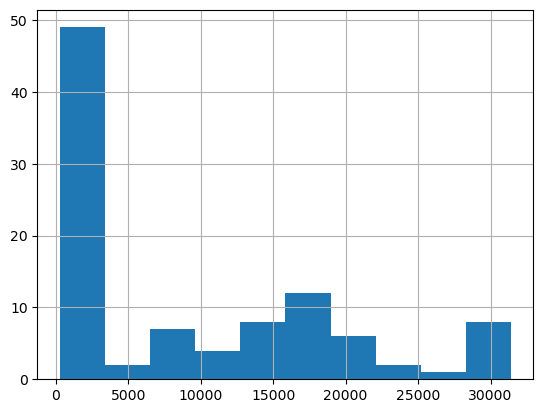

In [32]:
insitu_storage_df.groupby('tmsos_id').count()['storage'].hist()

In [33]:
# Merge combined_df with insitu_storage_df on 'date' and 'tmsos_id'
combined_df = combined_df.merge(
    insitu_storage_df[['date', 'tmsos_id', 'storage']],
    on=['date', 'tmsos_id'],
    how='left'
).rename(columns={'storage': 'insitu_storage'})

combined_df['insitu_storage'] = combined_df['insitu_storage'] * 1e6

# Display the first few rows to verify
combined_df.head()

date  uncorrected_area tmsos_id  unfiltered_area  cloud_percent  \
0 2019-01-07          7.821646     0078         7.893925       0.360967   
1 2019-01-12          7.998406     0078         7.999284      -0.168694   
2 2019-01-17          8.275234     0078         8.275234      -0.170002   
3 2019-01-22          1.545346     0078              NaN       1.400628   
4 2019-01-27          5.189810     0078              NaN       6.434594   

  sensor  date_dmy  climate  CAP_MCM  regularity  month    year  season  \
0     s2  20190107      9.0    317.3  197.322996    1.0  2019.0  Winter   
1     s2  20190112      9.0    317.3  197.322996    1.0  2019.0  Winter   
2     s2  20190117      9.0    317.3  197.322996    1.0  2019.0  Winter   
3     s2  20190122      9.0    317.3  197.322996    1.0  2019.0  Winter   
4     s2  20190127      9.0    317.3  197.322996    1.0  2019.0  Winter   

     elevation      slope  calculated_storage  swot_storage  swot_elevation  \
0  1133.519094  11.214282        1.860939e+08           NaN             NaN   
1  1133.519094  11.214282        1.860939e+08           NaN             NaN   
2  1133.519094  11.214282        1.860939e+08           NaN             NaN   
3  1133.519094  11.214282                 NaN           NaN             NaN   
4  1133.519094  11.214282                 NaN           NaN             NaN   

   insitu_storage  
0    1.860939e+08  
1    1.860939e+08  
2    1.860939e+08  
3             NaN  
4             NaN

Calculate normalized storage. i.e., storage time series as a percent of maximum capacity.

In [34]:
combined_df['swot_storage_smax_pct'] = combined_df['swot_storage'] * 100 / (combined_df['CAP_MCM']*1e6)
combined_df['normalized_storage_unfiltered_area'] = (combined_df['calculated_storage'] * 100) / (combined_df['CAP_MCM']*1e6)

In [35]:
combined_df

date  uncorrected_area tmsos_id  unfiltered_area  cloud_percent  \
0     2019-01-07          7.821646     0078         7.893925       0.360967   
1     2019-01-12          7.998406     0078         7.999284      -0.168694   
2     2019-01-17          8.275234     0078         8.275234      -0.170002   
3     2019-01-22          1.545346     0078              NaN       1.400628   
4     2019-01-27          5.189810     0078              NaN       6.434594   
...          ...               ...      ...              ...            ...   
58348 2024-08-29               NaN     1498              NaN            NaN   
58349 2024-08-30          0.000000     1498       592.520086     100.000000   
58350 2024-09-08               NaN     1498              NaN            NaN   
58351 2024-09-19               NaN     1498              NaN            NaN   
58352 2024-09-29               NaN     1498              NaN            NaN   

      sensor  date_dmy  climate  CAP_MCM  regularity  ...    year  season  \
0         s2  20190107      9.0    317.3  197.322996  ...  2019.0  Winter   
1         s2  20190112      9.0    317.3  197.322996  ...  2019.0  Winter   
2         s2  20190117      9.0    317.3  197.322996  ...  2019.0  Winter   
3         s2  20190122      9.0    317.3  197.322996  ...  2019.0  Winter   
4         s2  20190127      9.0    317.3  197.322996  ...  2019.0  Winter   
...      ...       ...      ...      ...         ...  ...     ...     ...   
58348    NaN       NaN      NaN      NaN         NaN  ...     NaN     NaN   
58349     s2  20240830     14.0   6287.7  822.143701  ...  2024.0  Summer   
58350    NaN       NaN      NaN      NaN         NaN  ...     NaN     NaN   
58351    NaN       NaN      NaN      NaN         NaN  ...     NaN     NaN   
58352    NaN       NaN      NaN      NaN         NaN  ...     NaN     NaN   

         elevation      slope  calculated_storage  swot_storage  \
0      1133.519094  11.214282        1.860939e+08           NaN   
1      1133.519094  11.214282        1.860939e+08           NaN   
2      1133.519094  11.214282        1.860939e+08           NaN   
3      1133.519094  11.214282                 NaN           NaN   
4      1133.519094  11.214282                 NaN           NaN   
...            ...        ...                 ...           ...   
58348          NaN        NaN                 NaN  4.638531e+09   
58349    56.207915   1.059950        3.123731e+09  4.665437e+09   
58350          NaN        NaN                 NaN  4.629086e+09   
58351          NaN        NaN                 NaN  4.616942e+09   
58352          NaN        NaN                 NaN  4.557951e+09   

       swot_elevation  insitu_storage  swot_storage_smax_pct  \
0                 NaN    1.860939e+08                    NaN   
1                 NaN    1.860939e+08                    NaN   
2                 NaN    1.860939e+08                    NaN   
3                 NaN             NaN                    NaN   
4                 NaN             NaN                    NaN   
...               ...             ...                    ...   
58348       50.880264             NaN                    NaN   
58349       50.959793             NaN              74.199427   
58350       50.852310             NaN                    NaN   
58351       50.816340             NaN                    NaN   
58352       50.641160             NaN                    NaN   

       normalized_storage_unfiltered_area  
0                               58.649181  
1                               58.649181  
2                               58.649181  
3                                     NaN  
4                                     NaN  
...                                   ...  
58348                                 NaN  
58349                           49.680029  
58350                                 NaN  
58351                                 NaN  
58352                                 NaN  

[58353 rows x 21 columns]

## Input data preparation

In [36]:
combined_df

date  uncorrected_area tmsos_id  unfiltered_area  cloud_percent  \
0     2019-01-07          7.821646     0078         7.893925       0.360967   
1     2019-01-12          7.998406     0078         7.999284      -0.168694   
2     2019-01-17          8.275234     0078         8.275234      -0.170002   
3     2019-01-22          1.545346     0078              NaN       1.400628   
4     2019-01-27          5.189810     0078              NaN       6.434594   
...          ...               ...      ...              ...            ...   
58348 2024-08-29               NaN     1498              NaN            NaN   
58349 2024-08-30          0.000000     1498       592.520086     100.000000   
58350 2024-09-08               NaN     1498              NaN            NaN   
58351 2024-09-19               NaN     1498              NaN            NaN   
58352 2024-09-29               NaN     1498              NaN            NaN   

      sensor  date_dmy  climate  CAP_MCM  regularity  ...    year  season  \
0         s2  20190107      9.0    317.3  197.322996  ...  2019.0  Winter   
1         s2  20190112      9.0    317.3  197.322996  ...  2019.0  Winter   
2         s2  20190117      9.0    317.3  197.322996  ...  2019.0  Winter   
3         s2  20190122      9.0    317.3  197.322996  ...  2019.0  Winter   
4         s2  20190127      9.0    317.3  197.322996  ...  2019.0  Winter   
...      ...       ...      ...      ...         ...  ...     ...     ...   
58348    NaN       NaN      NaN      NaN         NaN  ...     NaN     NaN   
58349     s2  20240830     14.0   6287.7  822.143701  ...  2024.0  Summer   
58350    NaN       NaN      NaN      NaN         NaN  ...     NaN     NaN   
58351    NaN       NaN      NaN      NaN         NaN  ...     NaN     NaN   
58352    NaN       NaN      NaN      NaN         NaN  ...     NaN     NaN   

         elevation      slope  calculated_storage  swot_storage  \
0      1133.519094  11.214282        1.860939e+08           NaN   
1      1133.519094  11.214282        1.860939e+08           NaN   
2      1133.519094  11.214282        1.860939e+08           NaN   
3      1133.519094  11.214282                 NaN           NaN   
4      1133.519094  11.214282                 NaN           NaN   
...            ...        ...                 ...           ...   
58348          NaN        NaN                 NaN  4.638531e+09   
58349    56.207915   1.059950        3.123731e+09  4.665437e+09   
58350          NaN        NaN                 NaN  4.629086e+09   
58351          NaN        NaN                 NaN  4.616942e+09   
58352          NaN        NaN                 NaN  4.557951e+09   

       swot_elevation  insitu_storage  swot_storage_smax_pct  \
0                 NaN    1.860939e+08                    NaN   
1                 NaN    1.860939e+08                    NaN   
2                 NaN    1.860939e+08                    NaN   
3                 NaN             NaN                    NaN   
4                 NaN             NaN                    NaN   
...               ...             ...                    ...   
58348       50.880264             NaN                    NaN   
58349       50.959793             NaN              74.199427   
58350       50.852310             NaN                    NaN   
58351       50.816340             NaN                    NaN   
58352       50.641160             NaN                    NaN   

       normalized_storage_unfiltered_area  
0                               58.649181  
1                               58.649181  
2                               58.649181  
3                                     NaN  
4                                     NaN  
...                                   ...  
58348                                 NaN  
58349                           49.680029  
58350                                 NaN  
58351                                 NaN  
58352                                 NaN  

[58353 rows x 21 columns]

## Cleaning and transforming features in input data

In [37]:
combined_df_all = combined_df.copy()

combined_df = combined_df[combined_df['swot_storage_smax_pct'] <= 200]
combined_df = combined_df[combined_df['swot_storage_smax_pct'] >= 0.1]
combined_df = combined_df.dropna(subset='swot_elevation')
combined_df = combined_df.dropna(subset='swot_elevation')
combined_df = combined_df.dropna(subset='unfiltered_area')  # drop time series points where swot_elevations are not present

combined_df = combined_df.loc[
    (combined_df['date'] >= TIME_RANGE[0]) & \
    (combined_df['date'] <= TIME_RANGE[1])
]

In [38]:
from sklearn.preprocessing import LabelEncoder

# Initialize the label encoders
sensor_encoder = LabelEncoder()
climate_encoder = LabelEncoder()
season_encoder = LabelEncoder()

input_df = combined_df.copy()

# Fit and transform the 'sensor' column
input_df['sensor'] = sensor_encoder.fit_transform(combined_df['sensor'])

# # Fit and transform the 'major_climate' column
# input_df['major_climate'] = climate_encoder.fit_transform(combined_df['major_climate'].astype(str))

# Fit and transform the 'season' column
input_df['season'] = season_encoder.fit_transform(combined_df['season'].astype(str))

# Print the mapping of sensor values
sensor_mapping = dict(zip(sensor_encoder.classes_, sensor_encoder.transform(sensor_encoder.classes_)))
print(sensor_mapping)

# # Print the mapping of major_climate values
# climate_mapping = dict(zip(climate_encoder.classes_, climate_encoder.transform(climate_encoder.classes_)))
# print(climate_mapping)

# Print the mapping of major_climate values
season_mapper = dict(zip(season_encoder.classes_, season_encoder.transform(season_encoder.classes_)))
print(season_mapper)

input_df.head()

{'l8': 0, 'l9': 1, 's2': 2}
{'Autumn': 0, 'Spring': 1, 'Summer': 2, 'Winter': 3}


date  uncorrected_area tmsos_id  unfiltered_area  cloud_percent  \
486 2023-12-09          6.265930     0078         6.498338       2.154084   
487 2023-12-12          0.000000     0078         7.379915     100.000000   
489 2023-12-17          7.159146     0078         7.159146      -0.172616   
490 2023-12-22          7.101814     0078         7.102107      -0.162164   
491 2023-12-25          6.983163     0078         7.117495       0.592402   

     sensor  date_dmy  climate  CAP_MCM  regularity  ...    year  season  \
486       0  20231209      9.0    317.3  197.322996  ...  2023.0       3   
487       2  20231212      9.0    317.3  197.322996  ...  2023.0       3   
489       2  20231217      9.0    317.3  197.322996  ...  2023.0       3   
490       2  20231222      9.0    317.3  197.322996  ...  2023.0       3   
491       0  20231225      9.0    317.3  197.322996  ...  2023.0       3   

       elevation      slope  calculated_storage  swot_storage  swot_elevation  \
486  1133.519094  11.214282        1.860939e+08  1.541675e+07      1075.13990   
487  1133.519094  11.214282        1.860939e+08  1.587609e+07      1075.40485   
489  1133.519094  11.214282        1.860939e+08  1.679477e+07      1075.93475   
490  1133.519094  11.214282        1.860939e+08  1.725411e+07      1076.19970   
491  1133.519094  11.214282        1.860939e+08  1.771345e+07      1076.46465   

     insitu_storage  swot_storage_smax_pct  normalized_storage_unfiltered_area  
486             NaN               4.858729                           58.649181  
487             NaN               5.003494                           58.649181  
489             NaN               5.293025                           58.649181  
490             NaN               5.437790                           58.649181  
491             NaN               5.582556                           58.649181  

[5 rows x 21 columns]

In [39]:
input_df.describe()

date  uncorrected_area  unfiltered_area  \
count                           4807       4807.000000      4807.000000   
mean   2024-02-03 22:04:58.065321216         50.731125        89.769077   
min              2023-07-21 00:00:00          0.000000         0.082865   
25%              2023-10-29 00:00:00          0.000000        15.199573   
50%              2024-02-03 00:00:00         14.050485        44.884054   
75%              2024-05-07 00:00:00         61.292429       124.595654   
max              2024-09-02 00:00:00        621.597529       622.474611   
std                              NaN         86.294527       110.722000   

       cloud_percent       sensor      climate       CAP_MCM   regularity  \
count    4807.000000  4807.000000  4807.000000   4807.000000  4807.000000   
mean       42.269213     1.543998    10.785313   2785.202933   430.457158   
min        -0.367199     0.000000     2.000000     41.000000   137.328198   
25%         0.342679     2.000000     3.000000    270.000000   263.186803   
50%        23.361846     2.000000    11.000000    803.000000   391.768554   
75%       100.000000     2.000000    14.000000   2300.000000   488.457674   
max       115.271077     2.000000    26.000000  36700.000000  1358.485515   
std        43.236973     0.833701     7.831061   5248.504159   221.547650   

             month         year       season    elevation        slope  \
count  4807.000000  4807.000000  4807.000000  4807.000000  4807.000000   
mean      6.634699  2023.583108     1.530684   468.953951     4.501335   
min       1.000000  2023.000000     0.000000    35.905120     0.359883   
25%       4.000000  2023.000000     1.000000   184.902509     1.602548   
50%       7.000000  2024.000000     2.000000   365.812350     2.436723   
75%       9.000000  2024.000000     2.000000   700.438985     6.086041   
max      12.000000  2024.000000     3.000000  1725.563127    22.003743   
std       3.403094     0.493096     1.094877   352.504655     4.357878   

       calculated_storage  swot_storage  swot_elevation  insitu_storage  \
count        4.807000e+03  4.807000e+03     4807.000000    4.510000e+02   
mean         1.233819e+09  2.103397e+09      439.167776    2.982896e+09   
min          4.243546e+02  2.167599e+05       28.619430    0.000000e+00   
25%          5.829697e+07  7.407347e+07      155.325111    1.397750e+08   
50%          2.644834e+08  2.757288e+08      346.588614    9.582500e+08   
75%          1.464616e+09  2.031795e+09      626.595360    5.564000e+09   
max          1.732372e+10  3.691841e+10     1702.092238    1.469291e+10   
std          2.179897e+09  5.065850e+09      342.399810    3.830954e+09   

       swot_storage_smax_pct  normalized_storage_unfiltered_area  
count            4807.000000                         4807.000000  
mean               58.715926                           43.189602  
min                 0.100306                            0.000056  
25%                21.497679                           14.811164  
50%                51.514540                           31.990504  
75%                83.168308                           64.607375  
max               199.192342                          199.655714  
std                45.875950                           36.198237

In [40]:
input_df.describe()

date  uncorrected_area  unfiltered_area  \
count                           4807       4807.000000      4807.000000   
mean   2024-02-03 22:04:58.065321216         50.731125        89.769077   
min              2023-07-21 00:00:00          0.000000         0.082865   
25%              2023-10-29 00:00:00          0.000000        15.199573   
50%              2024-02-03 00:00:00         14.050485        44.884054   
75%              2024-05-07 00:00:00         61.292429       124.595654   
max              2024-09-02 00:00:00        621.597529       622.474611   
std                              NaN         86.294527       110.722000   

       cloud_percent       sensor      climate       CAP_MCM   regularity  \
count    4807.000000  4807.000000  4807.000000   4807.000000  4807.000000   
mean       42.269213     1.543998    10.785313   2785.202933   430.457158   
min        -0.367199     0.000000     2.000000     41.000000   137.328198   
25%         0.342679     2.000000     3.000000    270.000000   263.186803   
50%        23.361846     2.000000    11.000000    803.000000   391.768554   
75%       100.000000     2.000000    14.000000   2300.000000   488.457674   
max       115.271077     2.000000    26.000000  36700.000000  1358.485515   
std        43.236973     0.833701     7.831061   5248.504159   221.547650   

             month         year       season    elevation        slope  \
count  4807.000000  4807.000000  4807.000000  4807.000000  4807.000000   
mean      6.634699  2023.583108     1.530684   468.953951     4.501335   
min       1.000000  2023.000000     0.000000    35.905120     0.359883   
25%       4.000000  2023.000000     1.000000   184.902509     1.602548   
50%       7.000000  2024.000000     2.000000   365.812350     2.436723   
75%       9.000000  2024.000000     2.000000   700.438985     6.086041   
max      12.000000  2024.000000     3.000000  1725.563127    22.003743   
std       3.403094     0.493096     1.094877   352.504655     4.357878   

       calculated_storage  swot_storage  swot_elevation  insitu_storage  \
count        4.807000e+03  4.807000e+03     4807.000000    4.510000e+02   
mean         1.233819e+09  2.103397e+09      439.167776    2.982896e+09   
min          4.243546e+02  2.167599e+05       28.619430    0.000000e+00   
25%          5.829697e+07  7.407347e+07      155.325111    1.397750e+08   
50%          2.644834e+08  2.757288e+08      346.588614    9.582500e+08   
75%          1.464616e+09  2.031795e+09      626.595360    5.564000e+09   
max          1.732372e+10  3.691841e+10     1702.092238    1.469291e+10   
std          2.179897e+09  5.065850e+09      342.399810    3.830954e+09   

       swot_storage_smax_pct  normalized_storage_unfiltered_area  
count            4807.000000                         4807.000000  
mean               58.715926                           43.189602  
min                 0.100306                            0.000056  
25%                21.497679                           14.811164  
50%                51.514540                           31.990504  
75%                83.168308                           64.607375  
max               199.192342                          199.655714  
std                45.875950                           36.198237

In [41]:
# deal with nans
print(f"length of input_df before dropping nans: {len(input_df)}")

input_df.loc[input_df['sensor'] == 2, 'cloud_pct'] = 0

# remove nans. Ignore nans in insitu_storage. for the period when swot is available, most insitu data is not available. 
# we won't be using it. Also ignore some other columns.

input_df = input_df.loc[:, input_df.columns.difference(['insitu_storage'])].dropna(how='any')

# # HACK: remove rows where swot_storages are 0
# input_df = input_df[input_df['swot_storage'] != 0]

print(f"length of input_df after dropping nans: {len(input_df)}")

length of input_df before dropping nans: 4807
length of input_df after dropping nans: 3689


In [42]:
input_df.isna().sum()

CAP_MCM                               0
calculated_storage                    0
climate                               0
cloud_pct                             0
cloud_percent                         0
date                                  0
date_dmy                              0
elevation                             0
month                                 0
normalized_storage_unfiltered_area    0
regularity                            0
season                                0
sensor                                0
slope                                 0
swot_elevation                        0
swot_storage                          0
swot_storage_smax_pct                 0
tmsos_id                              0
uncorrected_area                      0
unfiltered_area                       0
year                                  0
dtype: int64

In [43]:
features = [
    'uncorrected_area',
    'normalized_storage_unfiltered_area',
    'sensor',
    'month',
    'year',
    'climate',
    'regularity',
    'elevation',
    'slope',
    'cloud_percent',
    'season',
    'unfiltered_area',
]

X = input_df.loc[:, features]
X

uncorrected_area  normalized_storage_unfiltered_area  sensor  month  \
487            0.000000                           58.649181       2   12.0   
489            7.159146                           58.649181       2   12.0   
490            7.101814                           58.649181       2   12.0   
492            7.070200                           58.649181       2   12.0   
498            2.375407                           58.649181       2    1.0   
...                 ...                                 ...     ...    ...   
58340        595.937832                           54.490601       2    7.0   
58344        431.624310                           49.680029       2    8.0   
58345          0.000000                           49.680029       2    8.0   
58346          0.000000                           49.680029       2    8.0   
58349          0.000000                           49.680029       2    8.0   

         year  climate  regularity    elevation      slope  cloud_percent  \
487    2023.0      9.0  197.322996  1133.519094  11.214282     100.000000   
489    2023.0      9.0  197.322996  1133.519094  11.214282      -0.172616   
490    2023.0      9.0  197.322996  1133.519094  11.214282      -0.162164   
492    2023.0      9.0  197.322996  1133.519094  11.214282      -0.172616   
498    2024.0      9.0  197.322996  1133.519094  11.214282      60.390942   
...       ...      ...         ...          ...        ...            ...   
58340  2024.0     14.0  822.143701    56.207915   1.059950       3.954910   
58344  2024.0     14.0  822.143701    56.207915   1.059950      31.219059   
58345  2024.0     14.0  822.143701    56.207915   1.059950     100.000000   
58346  2024.0     14.0  822.143701    56.207915   1.059950     100.000000   
58349  2024.0     14.0  822.143701    56.207915   1.059950     100.000000   

       season  unfiltered_area  
487         3         7.379915  
489         3         7.159146  
490         3         7.102107  
492         3         7.070200  
498         3         7.881763  
...       ...              ...  
58340       2       611.058779  
58344       2       592.520086  
58345       2       592.520086  
58346       2       592.520086  
58349       2       592.520086  

[3689 rows x 12 columns]

In [44]:
X.isna().sum()

uncorrected_area                      0
normalized_storage_unfiltered_area    0
sensor                                0
month                                 0
year                                  0
climate                               0
regularity                            0
elevation                             0
slope                                 0
cloud_percent                         0
season                                0
unfiltered_area                       0
dtype: int64

In [45]:
y = input_df.loc[:, 'swot_storage_smax_pct']
y

487       5.003494
489       5.293025
490       5.437790
492       5.727321
498       6.818788
           ...    
58340    77.132592
58344    75.885797
58345    75.357225
58346    74.828652
58349    74.199427
Name: swot_storage_smax_pct, Length: 3689, dtype: float64

<Axes: >

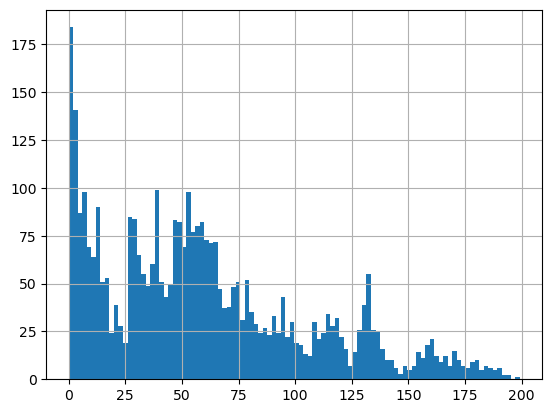

In [46]:
y.hist(bins=100)

In [47]:
from sklearn.model_selection import train_test_split

import xgboost as xgb
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=94)
base_reg = xgb.XGBRFRegressor(
    tree_method="hist"
)
base_reg.fit(
    X_train, y_train, eval_set=[(X_test, y_test)]
)
y_train_predicted = base_reg.predict(
    X_train
)
y_train_predicted
hv.Scatter(
    (list(y_train.values), list(y_train_predicted)), "Observed", "Predicted"
).opts(
    height=500, width=500, title='Observed vs Predicted on Training dataset'
)

[0]	validation_0-rmse:17.11979


:Scatter   [Observed]   (Predicted)

## Feature selection


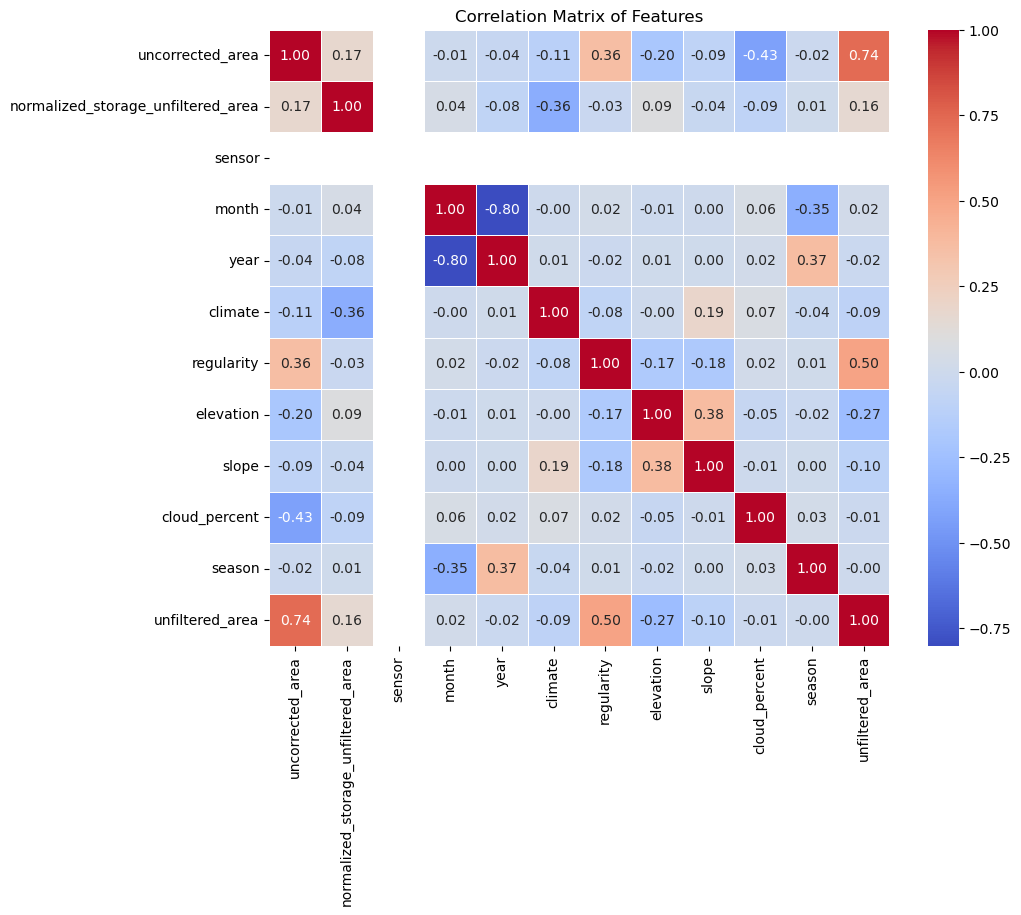

In [48]:
import seaborn as sns

import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = X.corr() 

# Create a heatmap to visualize the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Features')
plt.show()

Check mutual dependence between features and target.

In [49]:
X.isna()

uncorrected_area  normalized_storage_unfiltered_area  sensor  month  \
487               False                               False   False  False   
489               False                               False   False  False   
490               False                               False   False  False   
492               False                               False   False  False   
498               False                               False   False  False   
...                 ...                                 ...     ...    ...   
58340             False                               False   False  False   
58344             False                               False   False  False   
58345             False                               False   False  False   
58346             False                               False   False  False   
58349             False                               False   False  False   

        year  climate  regularity  elevation  slope  cloud_percent  season  \
487    False    False       False      False  False          False   False   
489    False    False       False      False  False          False   False   
490    False    False       False      False  False          False   False   
492    False    False       False      False  False          False   False   
498    False    False       False      False  False          False   False   
...      ...      ...         ...        ...    ...            ...     ...   
58340  False    False       False      False  False          False   False   
58344  False    False       False      False  False          False   False   
58345  False    False       False      False  False          False   False   
58346  False    False       False      False  False          False   False   
58349  False    False       False      False  False          False   False   

       unfiltered_area  
487              False  
489              False  
490              False  
492              False  
498              False  
...                ...  
58340            False  
58344            False  
58345            False  
58346            False  
58349            False  

[3689 rows x 12 columns]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'elevation'),
  Text(1, 0, 'regularity'),
  Text(2, 0, 'slope'),
  Text(3, 0, 'unfiltered_area'),
  Text(4, 0, 'normalized_storage_unfiltered_area'),
  Text(5, 0, 'climate'),
  Text(6, 0, 'uncorrected_area'),
  Text(7, 0, 'month'),
  Text(8, 0, 'season'),
  Text(9, 0, 'cloud_percent'),
  Text(10, 0, 'year'),
  Text(11, 0, 'sensor')])

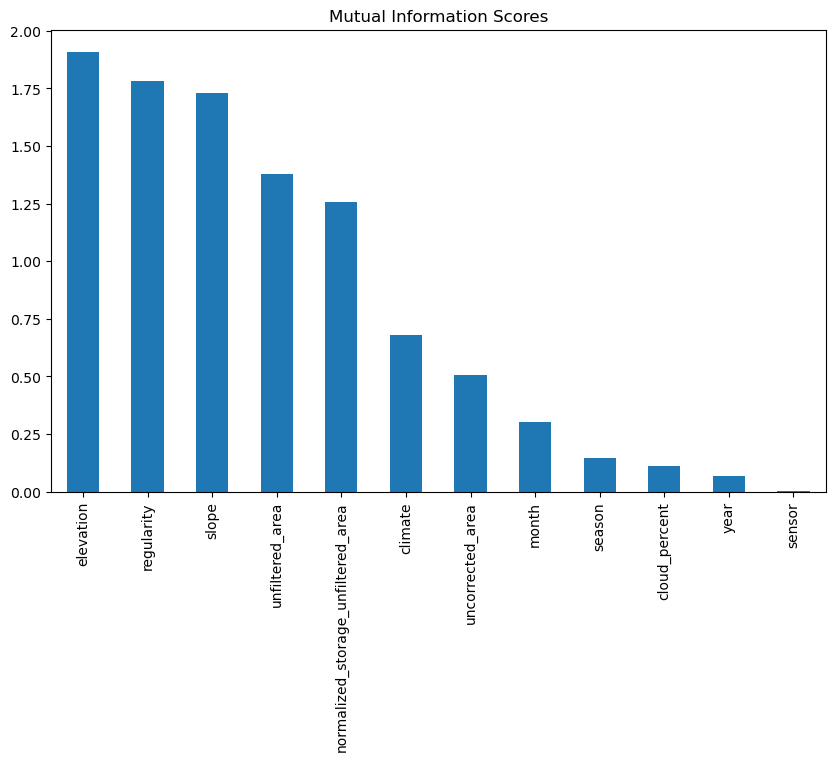

In [50]:
from sklearn.feature_selection import mutual_info_regression

mi_scores = mutual_info_regression(X, y)
mi_series = pd.Series(mi_scores, index=X.columns)

mi_series_sorted = mi_series.sort_values(ascending=False)

plt.figure(figsize=(10, 6))
mi_series_sorted.plot(kind='bar')
plt.title('Mutual Information Scores')
plt.xticks(rotation=90)

In [51]:
selected_features = [
    'elevation', 
    'slope', 
    'regularity', 
    'climate',
    # 'unfiltered_area', 
    'normalized_storage_unfiltered_area',
    # 'season',
    'cloud_percent',
    # '2_weekly_median_area',
    # 'rolling_zscore_30d',
    'month', 
] # non linear relation

X = X[selected_features]
X.head()

elevation      slope  regularity  climate  \
487  1133.519094  11.214282  197.322996      9.0   
489  1133.519094  11.214282  197.322996      9.0   
490  1133.519094  11.214282  197.322996      9.0   
492  1133.519094  11.214282  197.322996      9.0   
498  1133.519094  11.214282  197.322996      9.0   

     normalized_storage_unfiltered_area  cloud_percent  month  
487                           58.649181     100.000000   12.0  
489                           58.649181      -0.172616   12.0  
490                           58.649181      -0.162164   12.0  
492                           58.649181      -0.172616   12.0  
498                           58.649181      60.390942    1.0

# Train model

In [70]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
import lightgbm as lgb
import xgboost as xgb
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state=1)


# # 1. XGBoost
# reg = xgb.XGBRFRegressor(
#     tree_method="hist"
# )

# 2. Random forecast
reg = RandomForestRegressor(
    random_state=94, 
    n_estimators=200, 
    # criterion='absolute_error', 
    max_depth=10,
    max_leaf_nodes=512,
    min_samples_leaf=5,
    bootstrap=True,
)


# # 3. light gradient boost
# reg = lgb.LGBMRegressor(random_state=94)


# # 4. multi linear regression
# reg = LinearRegression()

# # # 5. ANN
# # Scale the features
# scaler_X = StandardScaler()
# scaler_y = StandardScaler()

# X_train_scaled = scaler_X.fit_transform(X_train.values)
# X_test_scaled = scaler_X.transform(X_test.values)

# # Reshape y to 2D array for scaling
# y_train_reshaped = y_train.values.reshape(-1, 1)
# y_test_reshaped = y_test.values.reshape(-1, 1)

# y_train_scaled = scaler_y.fit_transform(y_train_reshaped).ravel()
# y_test_scaled = scaler_y.transform(y_test_reshaped).ravel()

# reg = MLPRegressor(hidden_layer_sizes=(100, 50),  # Two hidden layers with 100 and 50 neurons
#                    activation='relu',              # ReLU activation function
#                    solver='adam',                  # Adam optimizer
#                    max_iter=1000,                  # Maximum number of iterations
#                    random_state=42)

# reg.fit(
#     X_train_scaled, y_train_scaled
# )
# # Predict on training data
# y_pred_scaled = reg.predict(X_train_scaled)
# y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).ravel()

# weights = (100 - X_train['cloud_percent'])
training_columns = X_train.columns.difference(['cloud_percent'])

reg.fit(
    X_train.loc[:, training_columns], 
    y_train, 
    # sample_weight=weights
)
# Predict on training data
y_pred = reg.predict(X_train.loc[:, training_columns])
y_pred_val = reg.predict(X_val.loc[:, training_columns].values)

# Predict on test data
ypred_test = reg.predict(X_test.loc[:, training_columns].values)
# yhat_test_scaled = reg.predict(X_test_scaled)
# yhat_test = scaler_y.inverse_transform(yhat_test_scaled.reshape(-1, 1)).ravel()

# Plot predictions for training data
train_plot = hv.Scatter(
    (list(y_train.values), list(y_pred)), "SWOT", "Predicted", label='Training set (75%)'
).opts(
    title="Storage (normalized by max capacity) predicted from\nuncorrected non-SWOT observations\ntrained on SWOT Storages\n(Random Forest Model)",
    height=500, width=500,
)

# Plot predictions for test data
test_plot = hv.Scatter(
    (list(y_test.values), list(ypred_test)), "SWOT", "Predicted", label='Testing set (25%)'
).opts(
    title="Storage (normalized by max capacity) predicted from\nuncorrected non-SWOT observations\ntrained on SWOT Storages\n(Random Forest Model)",
    height=500, width=500
)

# Display plots
(train_plot * test_plot).opts(legend_position='top_left')

/tiger1/pdas47/tmsosPP/.env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/tiger1/pdas47/tmsosPP/.env/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(


:Overlay
   .Scatter.Training_set_left_parenthesis_75_percent_right_parenthesis :Scatter   [SWOT]   (Predicted)
   .Scatter.Testing_set_left_parenthesis_25_percent_right_parenthesis  :Scatter   [SWOT]   (Predicted)

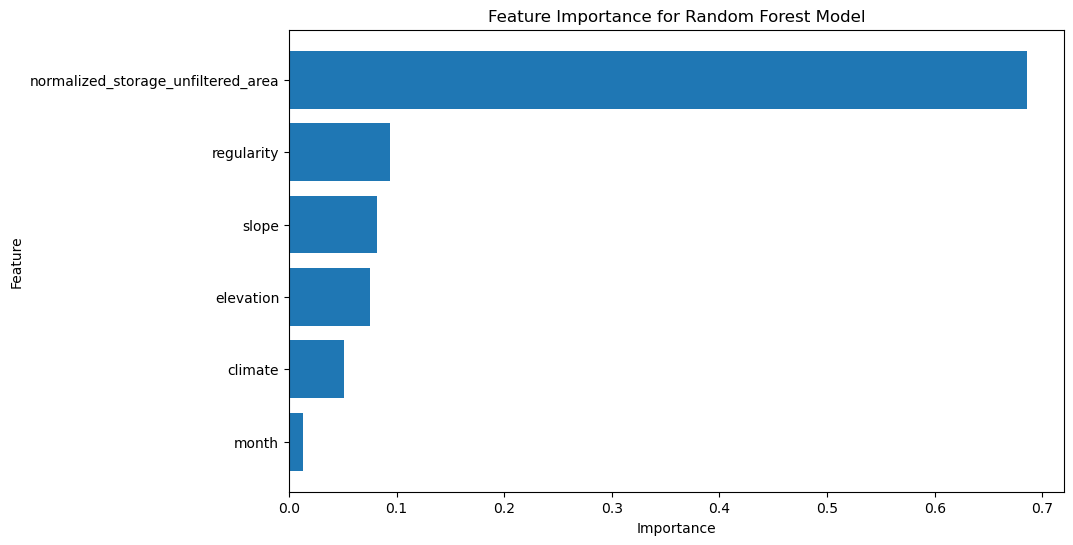

In [53]:
import pandas as pd

import matplotlib.pyplot as plt

# Assuming `reg` is your trained RandomForestRegressor model
feature_importances = reg.feature_importances_

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({
    'Feature': X[training_columns].columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance for Random Forest Model')
plt.gca().invert_yaxis()
plt.show()

In [54]:
combined_df

date  uncorrected_area tmsos_id  unfiltered_area  cloud_percent  \
486   2023-12-09          6.265930     0078         6.498338       2.154084   
487   2023-12-12          0.000000     0078         7.379915     100.000000   
489   2023-12-17          7.159146     0078         7.159146      -0.172616   
490   2023-12-22          7.101814     0078         7.102107      -0.162164   
491   2023-12-25          6.983163     0078         7.117495       0.592402   
...          ...               ...      ...              ...            ...   
58340 2024-07-31        595.937832     1498       611.058779       3.954910   
58344 2024-08-10        431.624310     1498       592.520086      31.219059   
58345 2024-08-15          0.000000     1498       592.520086     100.000000   
58346 2024-08-20          0.000000     1498       592.520086     100.000000   
58349 2024-08-30          0.000000     1498       592.520086     100.000000   

      sensor  date_dmy  climate  CAP_MCM  regularity  ...    year  season  \
486       l8  20231209      9.0    317.3  197.322996  ...  2023.0  Winter   
487       s2  20231212      9.0    317.3  197.322996  ...  2023.0  Winter   
489       s2  20231217      9.0    317.3  197.322996  ...  2023.0  Winter   
490       s2  20231222      9.0    317.3  197.322996  ...  2023.0  Winter   
491       l8  20231225      9.0    317.3  197.322996  ...  2023.0  Winter   
...      ...       ...      ...      ...         ...  ...     ...     ...   
58340     s2  20240731     14.0   6287.7  822.143701  ...  2024.0  Summer   
58344     s2  20240810     14.0   6287.7  822.143701  ...  2024.0  Summer   
58345     s2  20240815     14.0   6287.7  822.143701  ...  2024.0  Summer   
58346     s2  20240820     14.0   6287.7  822.143701  ...  2024.0  Summer   
58349     s2  20240830     14.0   6287.7  822.143701  ...  2024.0  Summer   

         elevation      slope  calculated_storage  swot_storage  \
486    1133.519094  11.214282        1.860939e+08  1.541675e+07   
487    1133.519094  11.214282        1.860939e+08  1.587609e+07   
489    1133.519094  11.214282        1.860939e+08  1.679477e+07   
490    1133.519094  11.214282        1.860939e+08  1.725411e+07   
491    1133.519094  11.214282        1.860939e+08  1.771345e+07   
...            ...        ...                 ...           ...   
58340    56.207915   1.059950        3.426206e+09  4.849866e+09   
58344    56.207915   1.059950        3.123731e+09  4.771471e+09   
58345    56.207915   1.059950        3.123731e+09  4.738236e+09   
58346    56.207915   1.059950        3.123731e+09  4.705001e+09   
58349    56.207915   1.059950        3.123731e+09  4.665437e+09   

       swot_elevation  insitu_storage  swot_storage_smax_pct  \
486       1075.139900             NaN               4.858729   
487       1075.404850             NaN               5.003494   
489       1075.934750             NaN               5.293025   
490       1076.199700             NaN               5.437790   
491       1076.464650             NaN               5.582556   
...               ...             ...                    ...   
58340       51.500465             NaN              77.132592   
58344       51.271274             NaN              75.885797   
58345       51.173521             NaN              75.357225   
58346       51.075769             NaN              74.828652   
58349       50.959793             NaN              74.199427   

       normalized_storage_unfiltered_area  
486                             58.649181  
487                             58.649181  
489                             58.649181  
490                             58.649181  
491                             58.649181  
...                                   ...  
58340                           54.490601  
58344                           49.680029  
58345                           49.680029  
58346                           49.680029  
58349                           49.680029  

[4807 rows x 21 columns]

In [58]:
# Ensure combined_df has the same features as the training data
predicted_df = combined_df.copy()

# # Transform the 'major_climate' column to labels
# predicted_df['major_climate'] = climate_encoder.transform(combined_df.loc[predicted_df.index, 'major_climate'].astype(str))
# Transform the 'major_climate' column to labels
predicted_df['season'] = season_encoder.transform(combined_df['season'].astype(str))

X_combined = predicted_df[training_columns]
X_combined = X_combined.dropna()
predicted_df = predicted_df.loc[X_combined.index]

# X_combined
# Predict the uncorrected_area using the trained model
# # Scale the features
# X_combined_scaled = scaler_X.transform(X_combined.values)

# # Predict the scaled storage values
# predicted_storage_scaled = reg.predict(X_combined)

# # Inverse transform the scaled storage values to get the original scale
# predicted_df['predicted_storage'] = scaler_y.inverse_transform(predicted_storage_scaled.reshape(-1, 1)).ravel()
# Predict the uncorrected_area using the trained model
predicted_df['predicted_swot_storage_percent'] = reg.predict(X_combined)

# Display the first few rows of the dataframe with the predictions
predicted_df[selected_features].head()

elevation      slope  regularity  climate  \
486  1133.519094  11.214282  197.322996      9.0   
487  1133.519094  11.214282  197.322996      9.0   
489  1133.519094  11.214282  197.322996      9.0   
490  1133.519094  11.214282  197.322996      9.0   
491  1133.519094  11.214282  197.322996      9.0   

     normalized_storage_unfiltered_area  cloud_percent  month  
486                           58.649181       2.154084   12.0  
487                           58.649181     100.000000   12.0  
489                           58.649181      -0.172616   12.0  
490                           58.649181      -0.162164   12.0  
491                           58.649181       0.592402   12.0

In [59]:
# Apply the function to each unique tmsos_id in predicted_df
for tmsos_id in predicted_df['tmsos_id'].unique():
    reservoir_df = predicted_df[predicted_df['tmsos_id'] == tmsos_id]
    aec = aec_dict.get(tmsos_id)
    print(tmsos_id)
    if aec is None:
        print(f"AEC unavailable for {tmsos_id}")
        continue
    if 'CumArea' not in aec.columns:
        print(f'wth, CumArea for {tmsos_id} is unavailable ')
    if aec is not None:
        predicted_storage = calculate_storage(aec, reservoir_df['unfiltered_area'])
    else:
        predicted_storage = pd.Series([np.nan] * len(reservoir_df), index=reservoir_df.index)
    predicted_df.loc[predicted_df['tmsos_id'] == tmsos_id, 'uncorrected_calculated_storage'] = predicted_storage.values

# # Display the first few rows of the dataframe with the calculated storage
# predicted_df[['date', 'tmsos_id', 'uncorrected_area', 'calculated_storage']].head()

0078
0079
0197
0214
0217
0335
0340
0349
0364
0365
0375
0440
0445
0484
0486
0487
0488
0492
0493
0498
0502
0503
0505
0507
0508
0512
0516
0518
0523
0524
0529
0530
0532
0535
0538
0549
0551
0552
0553
0569
0574
0576
0676
0725
0787
0803
0806
0807
0810
0812
0816
0817
0819
0820
0821
0824
0827
0828
0830
0833
0837
0839


/tiger1/pdas47/tmsosPP/src/tmsswot/tmsswot.py:31: UserWarning: Some area values are outside the bounds of the AEC DataFrame.
  warnings.warn("Some area values are outside the bounds of the AEC DataFrame.")
/tiger1/pdas47/tmsosPP/src/tmsswot/tmsswot.py:31: UserWarning: Some area values are outside the bounds of the AEC DataFrame.
  warnings.warn("Some area values are outside the bounds of the AEC DataFrame.")
/tiger1/pdas47/tmsosPP/src/tmsswot/tmsswot.py:31: UserWarning: Some area values are outside the bounds of the AEC DataFrame.
  warnings.warn("Some area values are outside the bounds of the AEC DataFrame.")
/tiger1/pdas47/tmsosPP/src/tmsswot/tmsswot.py:31: UserWarning: Some area values are outside the bounds of the AEC DataFrame.
  warnings.warn("Some area values are outside the bounds of the AEC DataFrame.")
/tiger1/pdas47/tmsosPP/src/tmsswot/tmsswot.py:31: UserWarning: Some area values are outside the bounds of the AEC DataFrame.
  warnings.warn("Some area values are outside the b

0930
0933
0934
0935
1078
1088
1097
1128
1134
1135
1162
1164
1177
1190
1239
1284
1298
1320
1383
1385
1392
1393
1398
1400
1407
1425
1426
1441
1444
1447
1487
1498


/tiger1/pdas47/tmsosPP/src/tmsswot/tmsswot.py:31: UserWarning: Some area values are outside the bounds of the AEC DataFrame.
  warnings.warn("Some area values are outside the bounds of the AEC DataFrame.")


In [60]:
predicted_df.head()

date  uncorrected_area tmsos_id  unfiltered_area  cloud_percent  \
486 2023-12-09          6.265930     0078         6.498338       2.154084   
487 2023-12-12          0.000000     0078         7.379915     100.000000   
489 2023-12-17          7.159146     0078         7.159146      -0.172616   
490 2023-12-22          7.101814     0078         7.102107      -0.162164   
491 2023-12-25          6.983163     0078         7.117495       0.592402   

    sensor  date_dmy  climate  CAP_MCM  regularity  ...    elevation  \
486     l8  20231209      9.0    317.3  197.322996  ...  1133.519094   
487     s2  20231212      9.0    317.3  197.322996  ...  1133.519094   
489     s2  20231217      9.0    317.3  197.322996  ...  1133.519094   
490     s2  20231222      9.0    317.3  197.322996  ...  1133.519094   
491     l8  20231225      9.0    317.3  197.322996  ...  1133.519094   

         slope  calculated_storage  swot_storage  swot_elevation  \
486  11.214282        1.860939e+08  1.541675e+07      1075.13990   
487  11.214282        1.860939e+08  1.587609e+07      1075.40485   
489  11.214282        1.860939e+08  1.679477e+07      1075.93475   
490  11.214282        1.860939e+08  1.725411e+07      1076.19970   
491  11.214282        1.860939e+08  1.771345e+07      1076.46465   

     insitu_storage  swot_storage_smax_pct  \
486             NaN               4.858729   
487             NaN               5.003494   
489             NaN               5.293025   
490             NaN               5.437790   
491             NaN               5.582556   

     normalized_storage_unfiltered_area  predicted_swot_storage_percent  \
486                           58.649181                        10.05074   
487                           58.649181                        10.05074   
489                           58.649181                        10.05074   
490                           58.649181                        10.05074   
491                           58.649181                        10.05074   

     uncorrected_calculated_storage  
486                    1.860939e+08  
487                    1.860939e+08  
489                    1.860939e+08  
490                    1.860939e+08  
491                    1.860939e+08  

[5 rows x 23 columns]

In [61]:
# max_limit = max(predicted_df['uncorrected_calculated_storage'].max(), predicted_df['predicted_storage'].max())
# min_limit = min(predicted_df['uncorrected_calculated_storage'].min(), predicted_df['predicted_storage'].min())

predicted_df.hvplot.scatter(
    x='swot_storage_smax_pct', 
    y='predicted_swot_storage_percent', 
    # title='Calculated Storage vs Predicted Storage',
    aspect='square'
).opts(
    frame_width=500, 
    frame_height=500,
    # xlim=(min_limit, max_limit),
    # ylim=(min_limit, max_limit),
    size=2

)

:Scatter   [swot_storage_smax_pct]   (predicted_swot_storage_percent)

# Prediction

## predict for reservoirs

In [62]:
def get_uncorrected(tmsos_id, column_name='uncorrected_areas'):
    df = combined_df[combined_df['tmsos_id'] == tmsos_id]
    if 'storage' not in df.columns:
        # Apply the function to each unique tmsos_id in predicted_df
        aec = aec_dict.get(tmsos_id)
        if aec is None:
            print(f"AEC unavailable for {tmsos_id}")
            return df
        if 'CumArea' not in aec.columns:
            print(f'wth, CumArea for {tmsos_id} is unavailable ')
        if aec is not None:
            predicted_storage = calculate_storage(aec, df[column_name])
        else:
            predicted_storage = pd.Series([np.nan] * len(df), index=df.index)
        df.loc[df['tmsos_id'] == tmsos_id, 'uncorrected_calculated_storage'] = predicted_storage.values
    return df

def get_swot(tmsos_id):
    return swot_storage_df[swot_storage_df['tmsos_id'] == tmsos_id]

def get_predicted(tmsos_id):
    return predicted_df[predicted_df['tmsos_id'] == tmsos_id]


# Example usage
time_series_df = get_uncorrected('0505', column_name='unfiltered_area')
time_series_df.head()

# Example usage
swot_rows_example = get_swot('0505')
swot_rows_example.head()

/tmp/ipykernel_3576426/2253084223.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['tmsos_id'] == tmsos_id, 'uncorrected_calculated_storage'] = predicted_storage.values


date  elevation       area       storage  storage_change tmsos_id
2386 2023-07-29  88.672910   0.000000  0.000000e+00             NaN     0505
2387 2023-08-06  89.031650   0.000000  0.000000e+00    0.000000e+00     0505
2388 2023-08-27  91.228870  19.984335  9.923252e+06    9.923252e+06     0505
2389 2023-09-09  91.695526  22.901642  1.493488e+07    5.011630e+06     0505
2390 2023-09-17  92.088066  25.094538  1.964846e+07    4.713581e+06     0505

In [63]:
# predicted_df

In [64]:
# uncorrected_areas

In [68]:
RESERVOIR = '0816'
RESERVOIR_NAME = val_pts[val_pts['tmsos_id'] == RESERVOIR]['name'].values[0]


uncorrected_areas = get_uncorrected(RESERVOIR, column_name='unfiltered_area')
swot_areas = get_swot(RESERVOIR)
predicted_areas = get_predicted(RESERVOIR)

# predicted_areas = predicted_areas.loc[
#     (predicted_areas['date'] >= TIME_RANGE[0]) & \
#     (predicted_areas['date'] >= TIME_RANGE[1])
# ]

uncorrected_areas_hv = hv.Scatter(
    uncorrected_areas, 'date', 'normalized_storage_unfiltered_area', label='L8, L9, S2 (training points)',
).opts(
    title=f'Storage for reservor {RESERVOIR}: {RESERVOIR_NAME}',
    xlabel='Date',
    ylabel='Storage (m³)',
    height=500,
    width=800,
)

swot_storage_hv = hv.Scatter(
    predicted_areas, 'date', 'swot_storage_smax_pct', label='SWOT'
).opts(
    title=f'Storage for reservor {RESERVOIR}: {RESERVOIR_NAME}',
    xlabel='Date',
    ylabel='SWOT Storage as percent of Capacity',
    height=500,
    width=800,
    color='red',
    size=4
)

predicted_storage_hv = hv.Scatter(
    predicted_areas, 'date', 'predicted_swot_storage_percent', label='Predicted SWOT storage'
).opts(
    title=f'Storage for reservor {RESERVOIR}: {RESERVOIR_NAME}',
    xlabel='Date',
    ylabel='SWOT Storage as percent of Capacity',
    height=500,
    width=800,
    color='black',
    size=4
)

swot_storage_hv * predicted_storage_hv * uncorrected_areas_hv

/tmp/ipykernel_3576426/2253084223.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[df['tmsos_id'] == tmsos_id, 'uncorrected_calculated_storage'] = predicted_storage.values


:Overlay
   .Scatter.SWOT                                                                    :Scatter   [date]   (swot_storage_smax_pct)
   .Scatter.Predicted_SWOT_storage                                                  :Scatter   [date]   (predicted_swot_storage_percent)
   .Scatter.L8_comma_L9_comma_S2_left_parenthesis_training_points_right_parenthesis :Scatter   [date]   (normalized_storage_unfiltered_area)

# Model performance

In [226]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score

# Regression metrics
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    return {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2_score': r2
    }

In [1]:
predicted_df.hvplot(
    x='swot_storage_smax_pct', y='predicted_swot_storage', kind='scatter', aspect='equal'
).opts(
    size=2, aspect='square'
)

NameError: name 'predicted_df' is not defined

In [228]:

# predicted_df.isna().sum()

In [229]:
# (predicted_df['swot_storage'] <= 0).sum()

In [234]:
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)  # Convert to million m³
    mae = mean_absolute_error(y_true, y_pred)  # Convert to million m³
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100  # Mean Absolute Percentage Error
    
    return {
        # 'mse': mse,
        'rmse (% of SMax)': rmse,
        'mae (% of SMax)': mae,
        # 'mape (%)': mape
    }


metrics_train = evaluate_regression(input_df.loc[X_train.index, 'swot_storage_smax_pct'], y_pred)
metrics_val = evaluate_regression(input_df.loc[X_val.index, 'swot_storage_smax_pct'], y_pred_val)

print("Training: ")
for (train_key, train_value), (val_key, val_value) in zip(metrics_train.items(), metrics_val.items()):
    print(f"{train_key}: {train_value:.3f}: TRAIN")
    print(f"{val_key}: {val_value:.3f}: VAL")
    print(f"{train_key}: {val_value - train_value:.3f}: VAL-TRAIN")
    print(f"\n")

Training: 
rmse (% of SMax): 11.670: TRAIN
rmse (% of SMax): 13.995: VAL
rmse (% of SMax): 2.325: VAL-TRAIN


mae (% of SMax): 6.193: TRAIN
mae (% of SMax): 7.422: VAL
mae (% of SMax): 1.229: VAL-TRAIN




/tiger1/pdas47/tmsosPP/.env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/tiger1/pdas47/tmsosPP/.env/lib/python3.12/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [235]:
# # ape = np.abs((predicted_df['swot_storage_smax_pct'] - predicted_df['predicted_swot_storage']) / predicted_df['swot_storage_smax_pct'])
# # hv.Scatter(
# #     (predicted_df['swot_storage_smax_pct'], ape), 'swot storage percent', 'absolute percent error'
# # )


# predicted_df['ape'] = np.abs((predicted_df['swot_storage_smax_pct'] - predicted_df['predicted_swot_storage_percent']) / predicted_df['swot_storage_smax_pct'])

# predicted_df.hvplot.scatter(
#     'swot_storage_smax_pct', 'ape', hover_cols=['tmsos_id', 'predicted_swot_storage_percent', 'normalized_storage_unfiltered_area']
# )


In [236]:

# predicted_df['squared_error'] = (predicted_df['swot_storage_smax_pct'] - predicted_df['predicted_swot_storage_percent']) ** 2

# predicted_df.hvplot.scatter(
#     'swot_storage_smax_pct', 'squared_error', hover_cols=['tmsos_id', 'predicted_swot_storage_percent', 'normalized_storage_unfiltered_area']
# )


In [237]:

# # Calculate absolute error
# predicted_df['absolute_error'] = abs(predicted_df['swot_storage_smax_pct'] - predicted_df['predicted_swot_storage_percent'])

# # Plot absolute error
# predicted_df.hvplot.scatter(
#     x='swot_storage_smax_pct', 
#     y='absolute_error', 
#     hover_cols=['tmsos_id', 'predicted_swot_storage', 'normalized_storage_unfiltered_area']
# )


In [239]:
from pathlib import Path

save_dir = Path("/tiger1/pdas47/tmsosPP/data/storage")
ALG = 'tmsospp'
VERSION = 'RF1_20241014'

for gp_name, gp in predicted_df.groupby('tmsos_id'):
    reservoir_name = val_pts[val_pts['tmsos_id'] == gp_name]['name'].values[0]
    save_fp = save_dir / ALG / f'{VERSION}' / f'{gp_name}_{reservoir_name.split(",")[0].replace(" ", "_")}_storage.csv'
    save_fp.parent.mkdir(exist_ok=True, parents=True)
    print(save_fp)

    gp['predicted_storage_m3'] = gp['predicted_swot_storage_percent'] * gp['CAP_MCM'] * 1e6

    gp_subset = gp[['date', 'tmsos_id', 'predicted_storage_m3']]

    gp_subset.to_csv(save_fp, index=False)

/tiger1/pdas47/tmsosPP/data/storage/tmsospp/RF1_20241014/0078_Juan_Benet_Dam_storage.csv
/tiger1/pdas47/tmsosPP/data/storage/tmsospp/RF1_20241014/0079_Riano_Dam_storage.csv
/tiger1/pdas47/tmsosPP/data/storage/tmsospp/RF1_20241014/0197_Tranco_de_Beas_Dam_storage.csv
/tiger1/pdas47/tmsosPP/data/storage/tmsospp/RF1_20241014/0214_Cijara_Dam_storage.csv
/tiger1/pdas47/tmsosPP/data/storage/tmsospp/RF1_20241014/0217_Cernadilla_Dam_storage.csv
/tiger1/pdas47/tmsosPP/data/storage/tmsospp/RF1_20241014/0335_Bronkhorstspruit_Dam_storage.csv
/tiger1/pdas47/tmsosPP/data/storage/tmsospp/RF1_20241014/0340_Arabie_Dam_storage.csv
/tiger1/pdas47/tmsosPP/data/storage/tmsospp/RF1_20241014/0349_Vaaldam_storage.csv
/tiger1/pdas47/tmsosPP/data/storage/tmsospp/RF1_20241014/0364_Koppies_Dam_storage.csv
/tiger1/pdas47/tmsosPP/data/storage/tmsospp/RF1_20241014/0365_Sterkfontein_Dam_storage.csv
/tiger1/pdas47/tmsosPP/data/storage/tmsospp/RF1_20241014/0375_R.K._Roux_storage.csv
/tiger1/pdas47/tmsosPP/data/storage/t